# 고전적인 방식은 인식률이 낮음 
- => 이미지 세그먼테이션 딥러닝 모델을 활용하여 페이지의 경계를 잡고, 원근변환 하는것이 좋을듯


In [4]:
# pip install opencv-python

2
12
10
7
6


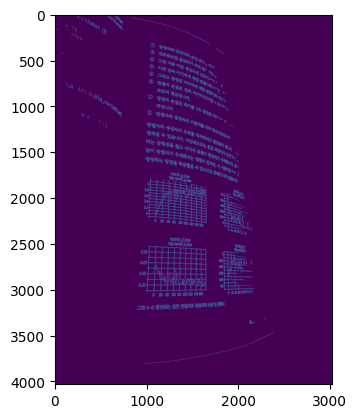

In [30]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def order_points(pts):
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    return rect

def four_point_transform(image, pts):
    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    return warped

# 이미지 로드
image = cv2.imread('./slite.jpg')
orig = image.copy()
# plt.imshow(orig)

# 그레이스케일 변환 및 가장자리 검출
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)
edged = cv2.Canny(gray, 75, 200)
plt.imshow(edged)


# 윤곽선 검출
contours, _ = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:5]


# 윤곽선을 순회하며 페이지 경계 찾기
for c in contours:
    # 윤곽선 근사화
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    print(len(approx))

    # 근사화된 윤곽선이 4개의 점을 갖고 있다면, 찾았다고 가정
    if len(approx) == 4:
        screenCnt = approx
        break


In [ ]:

# 찾은 경계로 원근 변환 수행
warped = four_point_transform(orig, screenCnt.reshape(4, 2))

# 변환된 이미지 출력
cv2.imshow("Scanned", warped)
cv2.waitKey(0)
cv2.destroyAllWindows()